In [34]:
import os
import boto3
import logging
from datetime import datetime

import sagemaker
import pandas as pd
import numpy as np
from sagemaker.transformer import Transformer

#### Settings

In [2]:
model_path = "s3://sagemaker-bucket-ds/iris_v2/model/iris-v2-xgboost-2024-06-24-14-45-10/output/model.tar.gz"
model_name = "iris-v2-xgboost-2024-06-24-14-45-10"
model_img = "685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest"

bucket_name = "sagemaker-bucket-ds"
project_path_s3 = 'iris_v2'
print(model_name)

iris-v2-xgboost-2024-06-24-14-45-10


#### Basic objects

In [11]:
sgmkr_clnt = boto3.client("sagemaker")
sgmkr_rt = boto3.client("runtime.sagemaker")
s3 = boto3.client('s3')
region = sagemaker.Session().boto_region_name
role_arn = sagemaker.get_execution_role()

#### Create model
This has to be done only once. The list of all models can be found in Sagemaker -> Inference -> Models

In [4]:
# The response is not an model object itself. It is used only to validate whether operation was successful
response = sgmkr_clnt.create_model(
    ModelName=model_name,
    PrimaryContainer={"Image": model_img, "ModelDataUrl": model_path},
    ExecutionRoleArn=role_arn,
)

print(response)

{'ModelArn': 'arn:aws:sagemaker:eu-west-1:211125740051:model/iris-v2-xgboost-2024-06-24-14-45-10', 'ResponseMetadata': {'RequestId': '75259441-7b65-4fe7-bb82-c8dc8897a9e6', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '75259441-7b65-4fe7-bb82-c8dc8897a9e6', 'content-type': 'application/x-amz-json-1.1', 'content-length': '97', 'date': 'Mon, 24 Jun 2024 14:51:17 GMT'}, 'RetryAttempts': 0}}


#### Create paths to data

In [5]:
batch_ip = 's3://{}/{}/{}'.format(bucket_name, project_path_s3, 'batch_inference_input') # Path to input
batch_op = 's3://{}/{}/{}'.format(bucket_name, project_path_s3, 'batch_inference_output') # Path to output

#### Create transformer
This is an object used for batch inference
Batch inference allows to calculate prediction for all observations in a folder.
The job will terminate as soon as the calculation are finished.
You dont need to delete or kill anything

In [6]:
transformer = Transformer(
    model_name=model_name,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=batch_op,
)

#### Make the actual batch inference

In [7]:
transformer.transform(
    data=batch_ip,
    data_type="S3Prefix",
    content_type="text/csv"
)
transformer.wait()

INFO:sagemaker:Creating transform job with name: xgboost-2024-06-24-14-51-29-451


............................Arguments: serve
[2024-06-24 14:56:14 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2024-06-24 14:56:14 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2024-06-24 14:56:14 +0000] [1] [INFO] Using worker: gevent
[2024-06-24 14:56:14 +0000] [20] [INFO] Booting worker with pid: 20
[2024-06-24 14:56:14 +0000] [21] [INFO] Booting worker with pid: 21
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)', 'urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)']. 
  monkey.patch_all(subprocess=True)
[2024-06-24:14

You can see the job in sagemaker -> inference -> batch inference
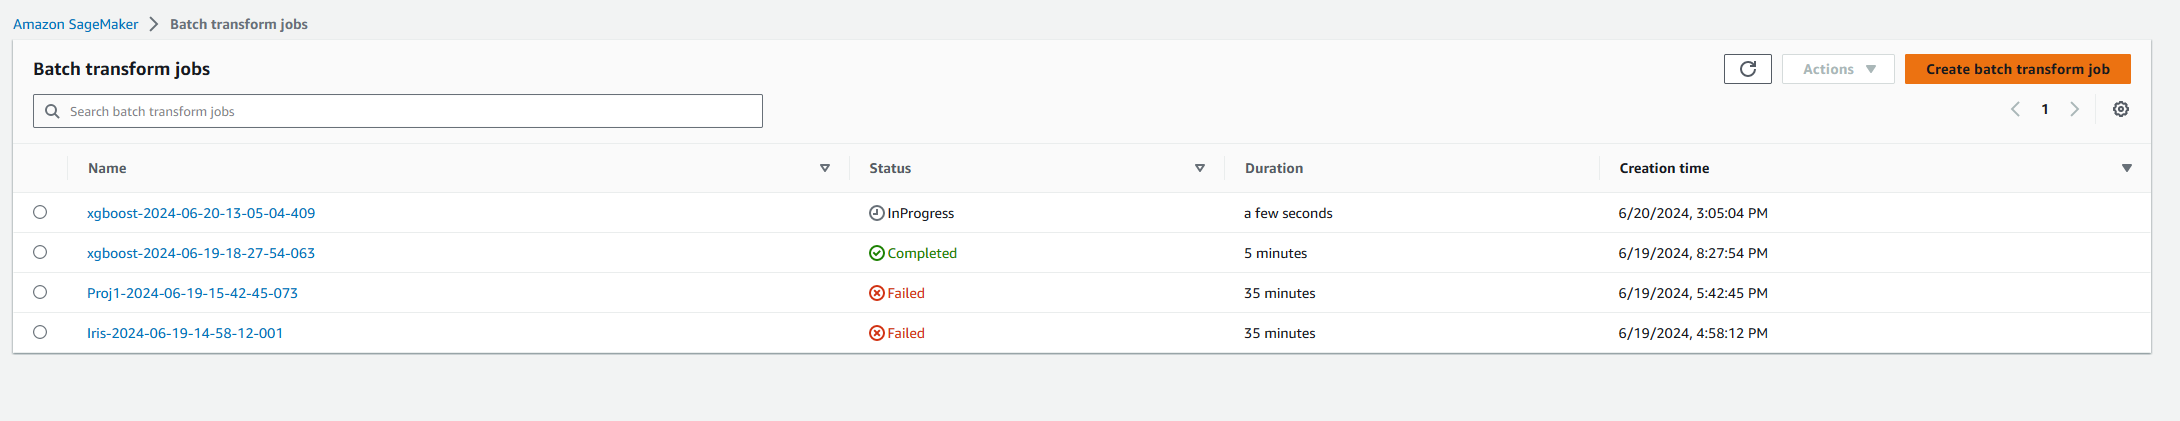

When you enter the setting ot he job you can see the model name
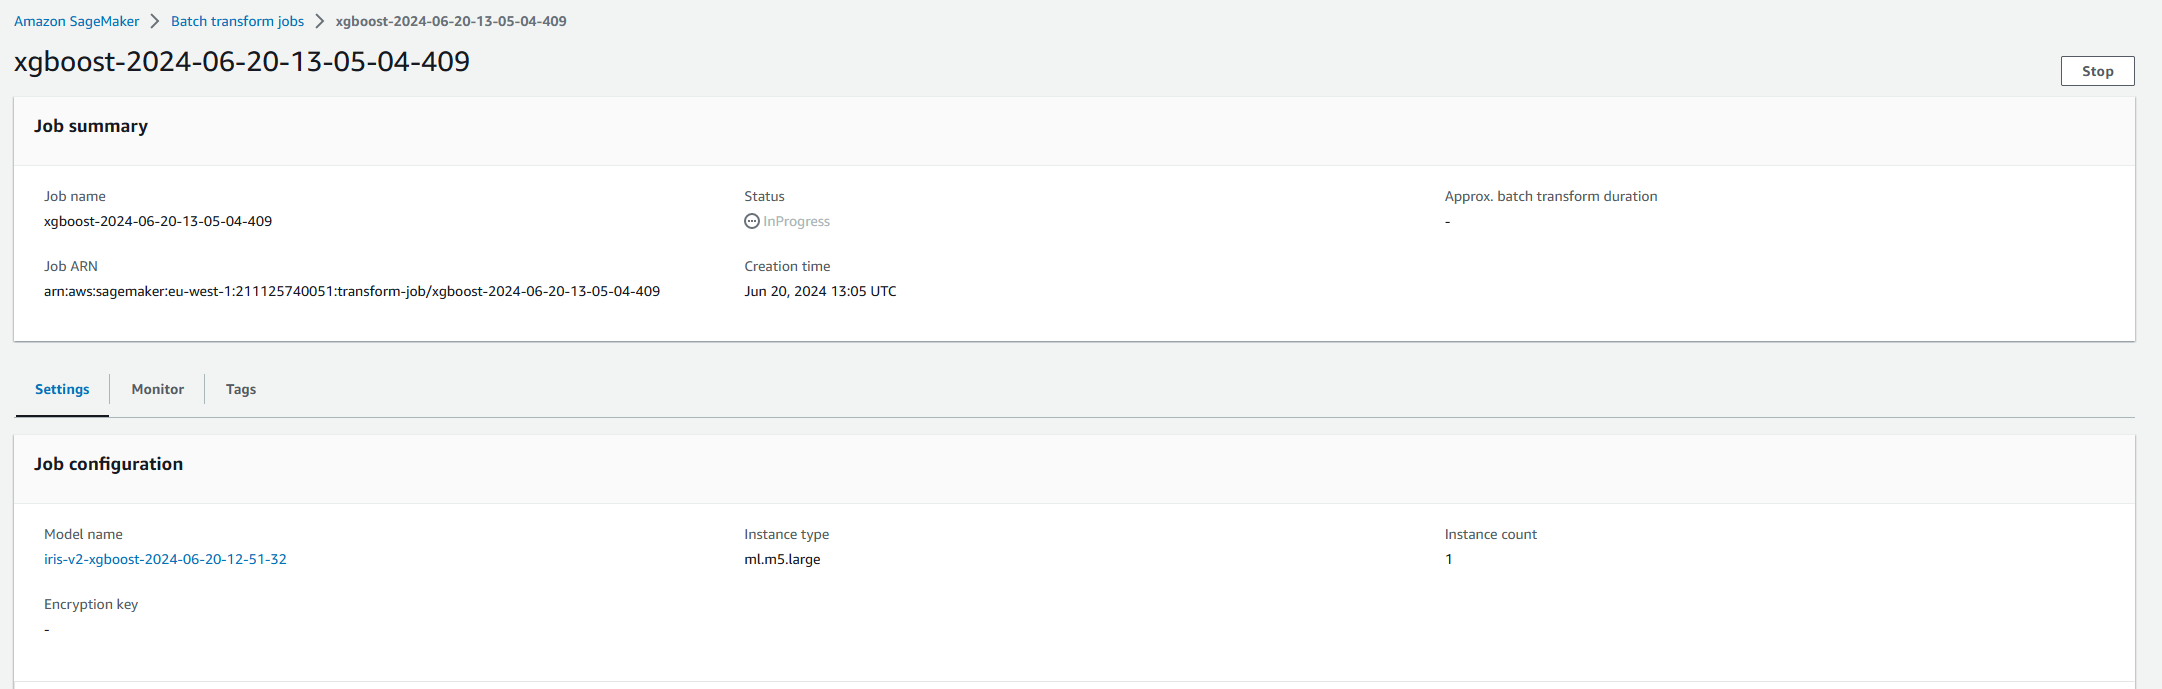

#### Lets check what is in the output folder

In [8]:
!aws s3 ls {batch_op} --recursive

2024-06-24 14:39:43          0 iris_v2/batch_inference_output/
2024-06-24 14:56:20       3203 iris_v2/batch_inference_output/iris_infer.csv.out
2024-06-24 15:09:53       1681 iris_v2/batch_inference_output/iris_infer_pred_normal.csv


In [18]:
file_key = 'iris_v2/batch_inference_output/iris_infer.csv.out' 

# Create an S3 client
s3_client = boto3.client('s3')

# Read the file from S3
response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
file_content = response['Body'].read().decode('utf-8')

# Split the file content into lines
lines = file_content.splitlines()

# Display the first few lines
num_lines_to_display = 10  # Change this to the number of lines you want to display
for line in lines[:num_lines_to_display]:
    print(line)

[0.088568314909935, 0.365761399269104, 0.5456702709197998]
[0.022942770272493362, 0.9030652046203613, 0.073992058634758]
[0.9490433931350708, 0.027127595618367195, 0.023829016834497452]
[0.024182245135307312, 0.9518529772758484, 0.02396479621529579]
[0.02426990307867527, 0.027125248685479164, 0.9486048221588135]
[0.024182245135307312, 0.9518529772758484, 0.02396479621529579]
[0.024182245135307312, 0.9518529772758484, 0.02396479621529579]
[0.9490433931350708, 0.027127595618367195, 0.023829016834497452]
[0.024182245135307312, 0.9518529772758484, 0.02396479621529579]
[0.027904359623789787, 0.9444421529769897, 0.027653444558382034]


#### Read results from sagemaker

In [32]:
# Read the file from S3
response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
df_pred_sm = pd.read_csv(response['Body'], header=None)

# Assign new column names
df_pred_sm.columns = ['pred_0', 'pred_1', 'pred_2']

# Remove square brackets
df_pred_sm = df_pred_sm.replace('\[', '', regex=True).replace('\]', '', regex=True)

# Convert data to float
df_pred_sm = df_pred_sm.applymap(lambda x: float(x))

/tmp/ipykernel_7434/1102746133.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_sm = df_pred_sm.applymap(lambda x: float(x))


#### Read results from normal model

In [29]:
# Helper function to read CSV file from S3
def read_csv_from_s3(s3_path):
    bucket, key = s3_path.replace("s3://", "").split("/", 1)
    obj = s3.get_object(Bucket=bucket, Key=key)
    return pd.read_csv(obj['Body'])

df_pred_normal = read_csv_from_s3("s3://sagemaker-bucket-ds/iris_v2/batch_inference_output/iris_infer_pred_normal.csv")

#### Compare results

In [35]:
# Ensure the dataframes have the same shape
if df_pred_sm.shape != df_pred_normal.shape:
    raise ValueError("The dataframes do not have the same shape.")

# Calculate the absolute differences
diff = np.abs(df_pred_sm - df_pred_normal)

# Create a boolean dataframe indicating matches
matches = diff < 0.0001

# Check if all values in each row match
row_matches = matches.all(axis=1)

# Add the result to the dataframe
comparison_results = df_pred_sm.copy()
comparison_results['match'] = row_matches

# Display the results
print(comparison_results)

      pred_0    pred_1    pred_2  match
0   0.088568  0.365761  0.545670   True
1   0.022943  0.903065  0.073992   True
2   0.949043  0.027128  0.023829   True
3   0.024182  0.951853  0.023965   True
4   0.024270  0.027125  0.948605   True
5   0.024182  0.951853  0.023965   True
6   0.024182  0.951853  0.023965   True
7   0.949043  0.027128  0.023829   True
8   0.024182  0.951853  0.023965   True
9   0.027904  0.944442  0.027653   True
10  0.949043  0.027128  0.023829   True
11  0.949043  0.027128  0.023829   True
12  0.949043  0.027128  0.023829   True
13  0.949043  0.027128  0.023829   True
14  0.949043  0.027128  0.023829   True
15  0.024270  0.027125  0.948605   True
16  0.093326  0.500424  0.406250   True
17  0.024182  0.951853  0.023965   True
18  0.024270  0.027125  0.948605   True
19  0.024182  0.951853  0.023965   True
20  0.024270  0.027125  0.948605   True
21  0.024182  0.951853  0.023965   True
22  0.949043  0.027128  0.023829   True
23  0.024270  0.027125  0.948605   True


#### Endpoint
- Endpoint is used for real time inference.
- To create an endpoint one must create endpoint configuration.
- Out of enpoint configuration an endpoint might be created.
- The user pays for the time that the endpoint is active, regardless whether it is used or not.
- Therefore, endpoint must be terminated once they are not used.
- On the other hand, endpoint configuration is free of charge and it needs to be created only once.

#### Endpoint settings

In [21]:
ep_config_name = "iris-v2-ep-config-" + datetime.today().strftime("%Y-%m-%d-%H-%M-%S-%f")
print(ep_config_name)

ep_name = "tmp-ep-iris-v2-" + datetime.today().strftime("%Y-%m-%d-%H-%M-%S-%f")
print(ep_name)

ep_config_variant = "version-1-created-at-2024-06-20-13-28-10"

iris-v2-ep-config-2024-06-20-13-28-10-939564


#### Create endpoint configuration

In [23]:
# The response is not an endpoint config object itself. It is used only to validate whether operation was successful
response = sgmkr_clnt.create_endpoint_config(
    EndpointConfigName=ep_config_name,
    ProductionVariants=[
        {
            "VariantName": ep_config_variant,
            "ModelName": model_name,
            "InitialInstanceCount": 1,
            "InstanceType": "ml.m4.large",
        },
    ],
)

print(response)

{'EndpointConfigArn': 'arn:aws:sagemaker:eu-west-1:211125740051:endpoint-config/iris-v2-ep-config-2024-06-20-13-28-10-939564', 'ResponseMetadata': {'RequestId': '2b5f8c03-9618-4968-883a-0058ac798953', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '2b5f8c03-9618-4968-883a-0058ac798953', 'content-type': 'application/x-amz-json-1.1', 'content-length': '125', 'date': 'Thu, 20 Jun 2024 13:29:06 GMT'}, 'RetryAttempts': 0}}


You can see endpoint configuration in Sagemaker -> Inference -> Endpoint configuration
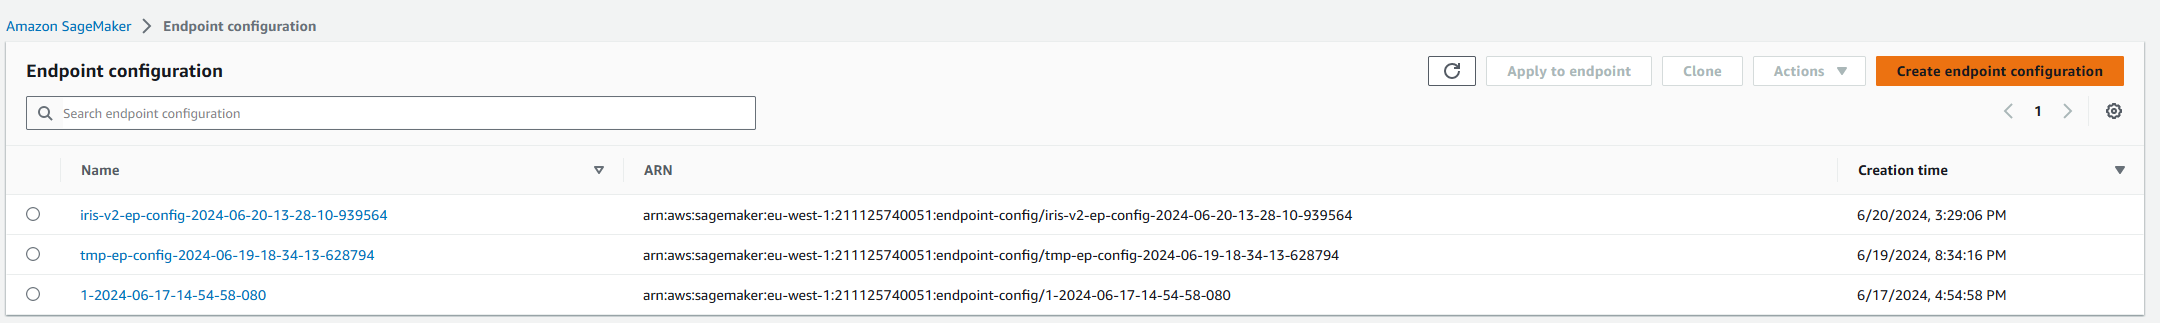

#### Create endpoint 

In [26]:
# The response is not an endpoint object itself. It is used only to validate whether operation was successful
response = sgmkr_clnt.create_endpoint(
    EndpointName=ep_name, EndpointConfigName=ep_config_name,
)
print(response)

{'EndpointArn': 'arn:aws:sagemaker:eu-west-1:211125740051:endpoint/tmp-ep-iris-v2-2024-06-20-13-29-22-123817', 'ResponseMetadata': {'RequestId': '14426872-f459-4f42-8112-2bee4a92f7aa', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '14426872-f459-4f42-8112-2bee4a92f7aa', 'content-type': 'application/x-amz-json-1.1', 'content-length': '109', 'date': 'Thu, 20 Jun 2024 13:31:35 GMT'}, 'RetryAttempts': 0}}


In [27]:
# It will wait till the endpoint is created
waiter = sgmkr_clnt.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=ep_name, WaiterConfig={"Delay": 123, "MaxAttempts": 123})
print("Endpoint created")

Endpoint created


You can see endpoints in Sagemaker -> Inference -> Endpoints
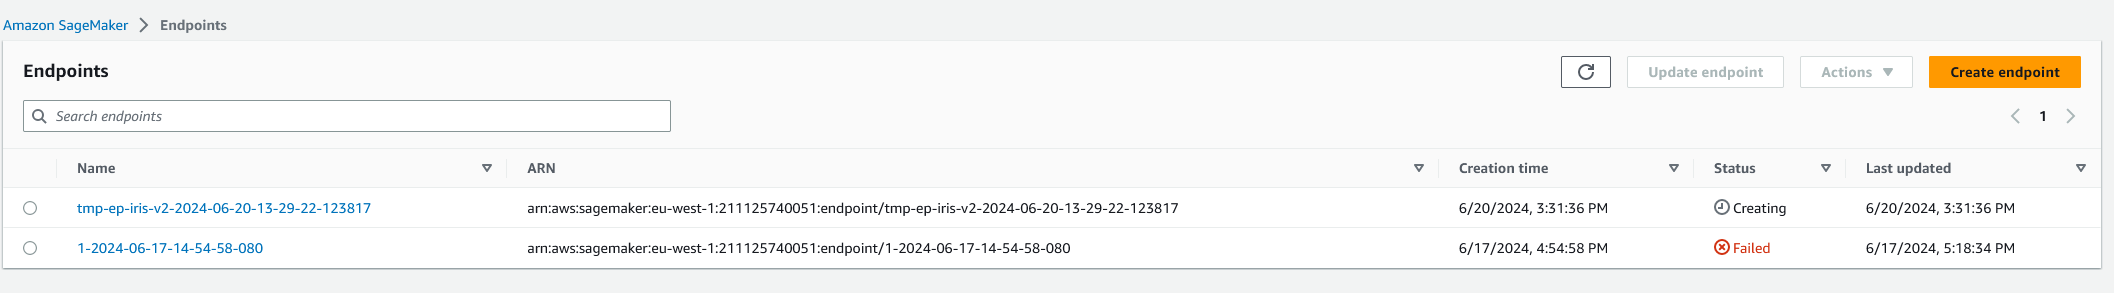

#### You can pass input to endpoint in the form of a comma separate string
This is not practical, however it shows how the endpoint actually works

In [28]:
payload = '7.7, 3.0, 6.1, 2.3 \n 7.9, 3.8, 6.4, 2.1'

sgmkr_runt = boto3.client("runtime.sagemaker")

response = sgmkr_runt.invoke_endpoint(
    EndpointName=ep_name, ContentType="text/csv", Body=payload,
)

prediction = response["Body"].read().decode()
print(prediction)

2.0,2.0


#### Calculate predictions from a file

In [31]:
csv_buffer = open("data/iris_infer.csv")
payload_csv_text = csv_buffer.read()

response = sgmkr_runt.invoke_endpoint(
    EndpointName=ep_name, ContentType="text/csv", Body=payload_csv_text
)
print(response["Body"].read().decode())

2.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,1.0,2.0


#### Delete the endpoint!

In [32]:
print("Deleting sagemaker endpoint")
response = sgmkr_clnt.delete_endpoint(EndpointName = ep_name)  
print("Deleted sagemaker endpoint")   

Deleting sagemaker endpoint
Deleted sagemaker endpoint


The endpoint has been deleted
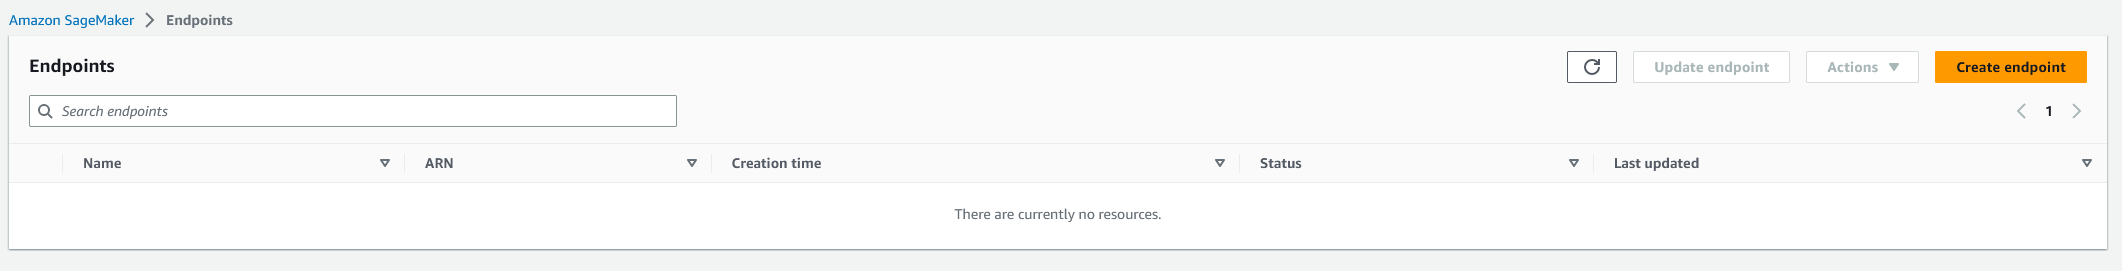

#### You can delete endpoint configuration, however it is not advised

In [ ]:
print("Deleting sagemaker endpoint configuration")
response = sgmkr_clnt.delete_endpoint_config(EndpointConfigName = endpoint_config_name)
print("Deleted sagemaker endpoint configuration")
#print(response)